# return & FDF & ADF
- 对一阶差分的return做统计分析
- 对close price做分数阶差分
- 对差分结果做ADF，找到满足序列平稳情况下，记忆力最强的序列

### 1. 导入必要的库

In [ ]:
# 1. Import dependencies and load Dollar Bars data
from pathlib import Path
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from src.utils.logger import logger


# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

project_root = Path.cwd().parent.parent  # two levels above notebooks/data_process/
bars_path = project_root / "data" / "preprocess_data" / "dollar_bars" / "BTCUSDT" / "BTCUSDT_dollar_bars_560k.csv"

df = pd.read_csv(bars_path)

### 2. return 统计数据

In [26]:
# 2. Compute log returns
col_data = df["timestamp"]

if np.issubdtype(col_data.dtype, np.number):
    ts = col_data.astype("int64")
    # Use number of digits to distinguish ms / us: <=13 digits -> ms, >13 digits -> us
    ts_len = ts.astype("string").str.len()
    ms_mask = ts_len <= 13
    us_mask = ts_len > 13
    logger.info(f"Time column timestamp: {ms_mask.sum()} rows as ms, {us_mask.sum()} rows as us")
    
    dt = pd.Series(index=ts.index, dtype="datetime64[ns]")
    if ms_mask.any():
        dt.loc[ms_mask] = pd.to_datetime(ts[ms_mask], unit="ms", errors="coerce")
    if us_mask.any():
        dt.loc[us_mask] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
    df["dt"] = dt

df = df.set_index("dt").sort_index()

# Compute log returns: log(p_t / p_{t-1})
df["log_ret"] = np.log(df["close"]).diff()

# Drop the first NaN
returns = df["log_ret"].dropna()

logger.info("Basic statistics of log returns:")
logger.info(f"\n{returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])}")

mean = returns.mean()
std = returns.std()
skew = stats.skew(returns)
kurt = stats.kurtosis(returns, fisher=True)  # Fisher=True -> 0 means normal distribution

logger.info(f"Mean: {mean}")
logger.info(f"Standard deviation: {std}")
logger.info(f"Skewness: {skew}")
logger.info(f"Kurtosis (Fisher): {kurt}")

| INFO     | __main__:<module>:10 - Time column timestamp: 410087 rows as ms, 82089 rows as us
| INFO     | __main__:<module>:27 - Basic statistics of log returns:
| INFO     | __main__:<module>:28 - 
count    4.921750e+05
mean     5.082542e-06
std      2.320168e-03
min     -6.720875e-02
1%      -6.205513e-03
5%      -3.367765e-03
50%      2.586311e-07
95%      3.364071e-03
99%      6.192177e-03
max      8.853553e-02
Name: log_ret, dtype: float64
| INFO     | __main__:<module>:35 - Mean: 5.0825418272296216e-06
| INFO     | __main__:<module>:36 - Standard deviation: 0.0023201675607042323
| INFO     | __main__:<module>:37 - Skewness: 0.3138125153890032
| INFO     | __main__:<module>:38 - Kurtosis (Fisher): 29.699840036888375


### 3. return 时序图 分布直方图 Boxplot图 QQ图 

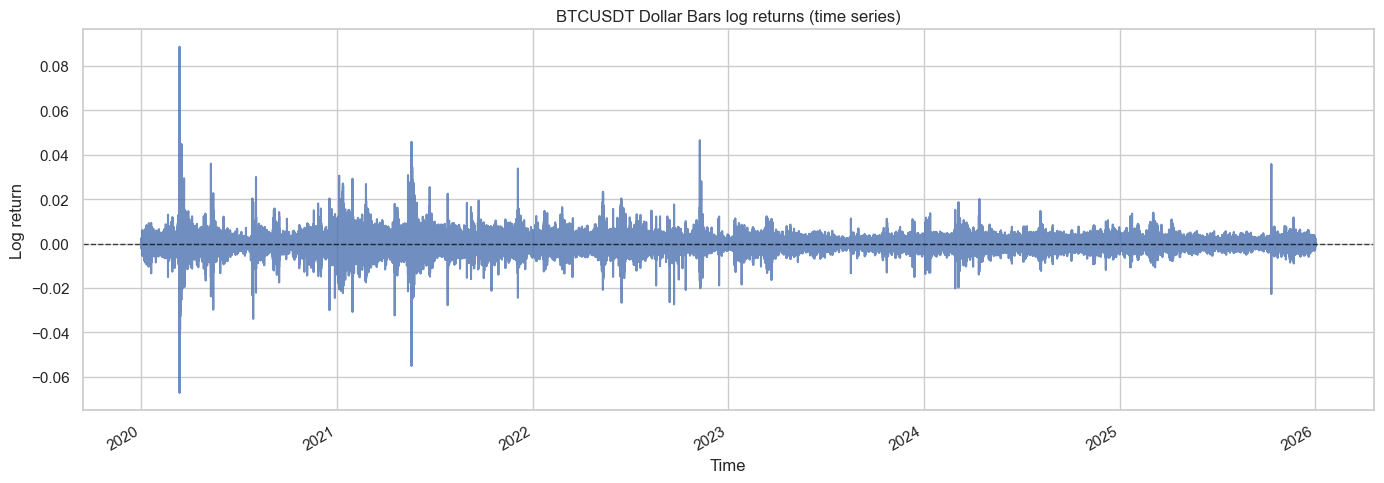

In [27]:
# 3. Time series of log returns
plt.figure(figsize=(14, 5))
returns.plot(alpha=0.8)
plt.title("BTCUSDT Dollar Bars log returns (time series)")
plt.xlabel("Time")
plt.ylabel("Log return")
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

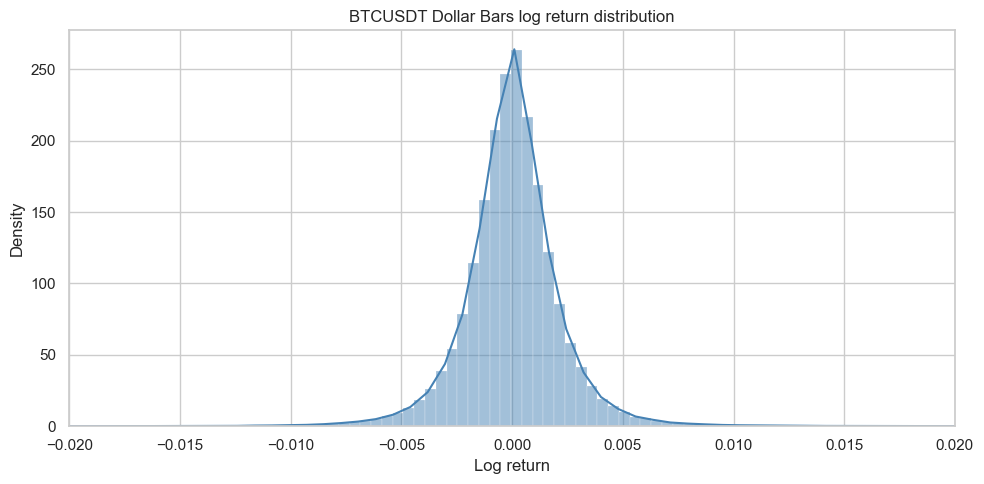

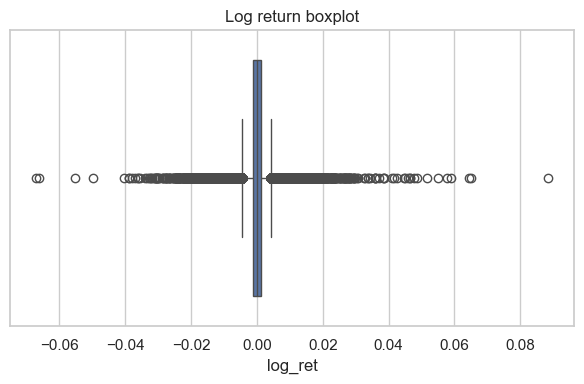

In [28]:
# 4. Distribution of log returns: histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=320, kde=True, stat="density", color="steelblue")
plt.title("BTCUSDT Dollar Bars log return distribution")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()

# 5. Boxplot to inspect tails and skewness
plt.figure(figsize=(6, 4))
sns.boxplot(x=returns, orient="h")
plt.title("Log return boxplot")
plt.tight_layout()
plt.show()

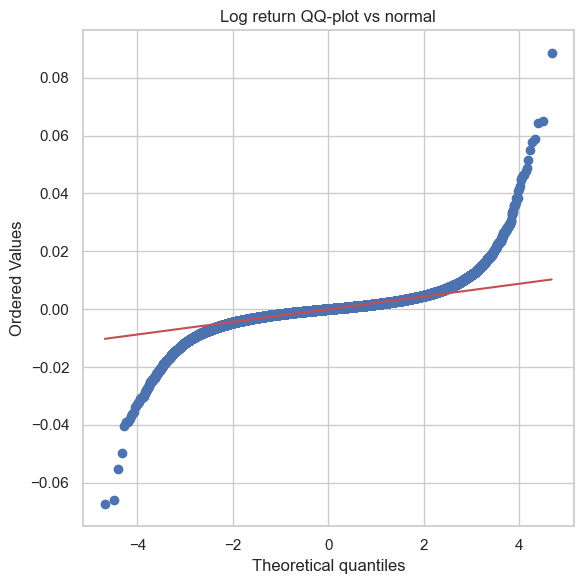

In [29]:
# 6. QQ plot
fig = plt.figure(figsize=(6, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Log return QQ-plot vs normal")
plt.tight_layout()
plt.show()

### 4. 对return做ADF

In [ ]:
# ADF (Augmented Dickey-Fuller) unit root test for return series.
# Goal: check if returns are stationary (reject H0 -> stationary).
def ADF(ret_series):
    # 1) Prepare the return series: drop NaN/inf and ensure 1D float array.
    #    ADF is sensitive to missing values; we clean explicitly to avoid silent errors.
    ret_series = ret_series.replace([np.inf, -np.inf], np.nan).dropna()
    ret_values = ret_series.to_numpy(dtype=float)

    # 2) Choose test settings.
    #    - regression: 'c' includes a constant (mean) term only; common for returns.
    #    - autolag: 'AIC' lets the test pick lag length to reduce autocorrelation.
    adf_result = adfuller(ret_values, regression="c", autolag="AIC")

    # 3) Unpack results for readability.
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    used_lag = adf_result[2]
    n_obs = adf_result[3]
    crit_values = adf_result[4]
    ic_best = adf_result[5]

    # 4) Report key outputs in a compact, interpretable format.
    logger.info(f"ADF Statistic: {adf_stat}")
    logger.info(f"p-value: {p_value}")
    logger.info(f"Used lag: {used_lag}")
    logger.info(f"Number of observations: {n_obs}")
    logger.info(f"Best IC (AIC): {ic_best}")
    logger.info(f"Critical values:")
    for level, value in crit_values.items():
        logger.info(f"{level}: {value}")
    
    # 5) Simple decision rule at 5% level (can adjust as needed).
    if p_value < 0.05:
        logger.info("Conclusion: reject H0 (unit root). Returns appear stationary.")
    else:
        logger.info("Conclusion: fail to reject H0. Returns may be non-stationary.")

ADF(returns)

| INFO     | __main__:<module>:26 - ADF Statistic: -71.00022900181575
| INFO     | __main__:<module>:27 - p-value: 0.0
| INFO     | __main__:<module>:28 - Used lag: 101
| INFO     | __main__:<module>:29 - Number of observations: 492073
| INFO     | __main__:<module>:30 - Best IC (AIC): -4574172.632042437
| INFO     | __main__:<module>:31 - Critical values:
| INFO     | __main__:<module>:33 - 1%: -3.430363289357703
| INFO     | __main__:<module>:33 - 5%: -2.861545873739475
| INFO     | __main__:<module>:33 - 10%: -2.5667731263769977
| INFO     | __main__:<module>:37 - Conclusion: reject H0 (unit root). Returns appear stationary.


### 5. 计算FDF

In [ ]:
# Fractional Differencing (FFD) on log close and ADF test with Numba acceleration.
from tqdm import tqdm
import numba

# 1) Build a clean log-close series (the target for fractional differencing).
#    Reuse the same cleaning pattern as ADF: remove NaN/inf explicitly.
log_close = np.log(df["close"]).replace([np.inf, -np.inf], np.nan).dropna()

# 2) FFD helper: compute fixed-width weights until the tail weight is small.
#    Limit to max_width=500 to avoid losing all data for very small d values.
def get_weights_ffd(d, thresh=1e-5, max_width=500):
    """Return fixed-width weights for fractional differencing with max width limit."""
    weights = [1.0]
    k = 1
    while True:
        w_k = -weights[-1] * (d - k + 1) / k
        if abs(w_k) < thresh or len(weights) >= max_width:
            break
        weights.append(w_k)
        k += 1
    # Reverse so the newest observation aligns with the last weight.
    return np.array(weights[::-1], dtype=np.float64)

# 3) Numba-compiled FFD computation: core loop compiled to machine code for 10-100x speedup.
#    @numba.jit compiles the tight loop to native code, bypassing Python GIL.
@numba.jit(nopython=True, cache=True)
def frac_diff_ffd_numba(values, weights):
    """Numba-compiled FFD: apply weights to sliding windows over values array."""
    width = len(weights)
    n = len(values)
    out = np.full(n, np.nan, dtype=np.float64)
    # Compute FFD: dot product of weights with each window.
    for i in range(width - 1, n):
        window = values[i - width + 1 : i + 1]
        # Check for NaN in window.
        has_nan = False
        for j in range(width):
            if np.isnan(window[j]):
                has_nan = True
                break
        if not has_nan:
            out[i] = np.dot(weights, window)
    return out

def frac_diff_ffd(series, d, thresh=1e-5):
    """Apply fixed-width fractional differencing with Numba acceleration and width limit."""
    weights = get_weights_ffd(d, thresh=thresh, max_width=500)
    values = series.to_numpy(dtype=np.float64)
    # Call Numba-compiled inner loop for 10-100x speedup.
    out_values = frac_diff_ffd_numba(values, weights)
    return pd.Series(out_values, index=series.index)

# 4) ADF summary helper with minimum sample size check and explicit maxlag limit.
#    - min_obs: requires at least 100 valid observations.
#    - maxlag: explicitly limit to 12 (monthly-like lags) to avoid memory blow-up when auto-computing.
def adf_summary(series, min_obs=100, maxlag=12):
    """Run ADF on a series and return p-value, n_obs, used_lag, adf_stat as dict.
    maxlag explicitly set to avoid memory overflow from internal auto-lag calculation.
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean) < min_obs:
        # Not enough data for reliable ADF test; return NaN.
        return {"p_value": np.nan, "n_obs": len(clean), "used_lag": np.nan, "adf_stat": np.nan}
    # Key fix: maxlag is explicitly limited (default 12) to prevent memory explosion.
    # ADF will search from lag 0 to maxlag using autolag='AIC' internally.
    adf = adfuller(clean.to_numpy(dtype=float), regression="c", autolag="AIC", maxlag=maxlag)
    return {"p_value": adf[1], "n_obs": adf[3], "used_lag": adf[2], "adf_stat": adf[0]}

# 5) Scan d from low to high with Numba-accelerated FFD (single-threaded, no GIL contention).
#    - Numba compiles FFD loops to fast machine code: ~10-100x speedup per call.
#    - Weight limit + minimum sample check + explicit maxlag prevent memory overflow.
#    - tqdm shows progress bar with ETA and speed.
d_grid = np.round(np.arange(0.0, 1.01, 0.01), 2)
results = []

logger.info(f"Starting FFD+ADF scan with Numba acceleration: {len(d_grid)} d values.")
for d in tqdm(d_grid, desc="ADF scan", unit="d"):
    ffd = frac_diff_ffd(log_close, d, thresh=1e-5)
    adf_info = adf_summary(ffd, min_obs=100, maxlag=12)
    results.append({"d": d, **adf_info})

results_df = pd.DataFrame(results)
logger.info("ADF scan completed for FFD log-close.")
logger.info(f"\nResults summary (first 5):")
logger.info(results_df.head(5).to_string(index=False))
logger.info(f"\nResults summary (last 5):")
logger.info(results_df.tail(5).to_string(index=False))
logger.info(f"\nFiltered results (valid ADF, >= 100 obs):")
valid_obs = results_df[results_df["n_obs"] >= 100]
logger.info(f"Total: {len(results_df)} d values, {len(valid_obs)} with sufficient data.")

# 6) Choose best d = smallest d with p-value < 0.05 (max memory under stationarity).
valid = results_df[results_df["p_value"] < 0.05]
if not valid.empty:
    best_row = valid.iloc[0]
    best_d = float(best_row["d"])
    best_p = float(best_row["p_value"])
    best_nobs = int(best_row["n_obs"])
    logger.info(f"\n{'='*60}")
    logger.info(f"Best d (max memory, ADF pass): {best_d}")
    logger.info(f"ADF p-value at best d: {best_p:.6f}")
    logger.info(f"Valid observations: {best_nobs}")
    logger.info(f"{'='*60}")
    # Compute the final FFD series for downstream use.
    ffd_best = frac_diff_ffd(log_close, best_d, thresh=1e-5)
    # Detailed ADF results on the chosen series (inline adfuller to avoid dependency).
    logger.info(f"\nDetailed ADF results for best FFD series (d={best_d}):")
    ffd_best_clean = ffd_best.replace([np.inf, -np.inf], np.nan).dropna()
    adf_result_best = adfuller(ffd_best_clean.to_numpy(dtype=float), regression="c", autolag="AIC", maxlag=12)
    logger.info(f"ADF Statistic: {adf_result_best[0]:.6f}")
    logger.info(f"p-value: {adf_result_best[1]:.6f}")
    logger.info(f"Used lag: {adf_result_best[2]}")
    logger.info(f"Number of observations: {adf_result_best[3]}")
    logger.info(f"Best IC (AIC): {adf_result_best[5]:.6f}")
    logger.info(f"Critical values:")
    for level, value in adf_result_best[4].items():
        logger.info(f"  {level}: {value:.6f}")
    if adf_result_best[1] < 0.05:
        logger.info(f"✓ Conclusion: reject H0 (unit root). FFD series is stationary.")
    else:
        logger.info(f"✗ Conclusion: fail to reject H0. FFD series may be non-stationary.")
else:
    best_d = None
    ffd_best = pd.Series(dtype=float, index=log_close.index)
    logger.info("No d in grid passes ADF at 5% level.")

| INFO     | __main__:<module>:76 - Starting FFD+ADF scan with Numba acceleration: 101 d values.


ADF scan:   0%|          | 0/101 [00:00<?, ?d/s]

ADF scan: 100%|██████████| 101/101 [06:22<00:00,  3.78s/d]

| INFO     | __main__:<module>:83 - ADF scan completed for FFD log-close.
| INFO     | __main__:<module>:84 - 
Results summary (first 5):
| INFO     | __main__:<module>:85 -    d  p_value  n_obs  used_lag  adf_stat
0.00 0.386285 492163        12 -1.788301
0.01 0.354362 491664        12 -1.853253
0.02 0.348353 491664        12 -1.865724
0.03 0.340977 491664        12 -1.881156
0.04 0.332204 491664        12 -1.899696
| INFO     | __main__:<module>:86 - 
Results summary (last 5):
| INFO     | __main__:<module>:87 -    d  p_value  n_obs  used_lag    adf_stat
0.96      0.0 492095        12 -145.867782
0.97      0.0 492105        12 -156.233071
0.98      0.0 492117        12 -167.327362
0.99      0.0 492131        12 -180.856185
1.00      0.0 492162        12 -196.582215
| INFO     | __main__:<module>:88 - 
Filtered results (valid ADF, >= 100 obs):
| INFO     | __main__:<module>:90 - Total: 101 d values, 101 with sufficient data.
| INFO     | __main__:<module>:99 - 
| INFO     | __main__:<m

| INFO     | __main__:<module>:107 - 
Detailed ADF results for best FFD series (d=0.21):


NameError: name 'ADF' is not defined